**1. Introducing the Data**    
**2. Data Cleaning and Feature Engineering**     
A. Handling missing data                    
B. Dealing with Data Types (Feature Engineering)                                                
**3. Data Exploration**     
A. Target Distributions         
B. Feature Distributions    
C. OverSampling (due to Target imbalance)               
**4. Modeling**          
A. Baseline                                              
B. Bagging Algorithm (Random Forest) (Parallel Learners)                                               
C. Boosting Algorithm (Gradient Boosting)  (Serial Learners)                                
D. Feature Importance  
E. Gradient Boosting (after Feature extraction)
**5. Conclusion**           
A. Winner

## 1. Introduction the Data

This is a supervised binary classification model whose goal is to predict "False" 911 Calls. "False" 911 calls are defined as calls that were either without any merit, subsequently cancelled and/or where the responding authorities failed to locate the subject resulting in a waste of taxpayers' dollars.

The dataset consists of 911 calls made in the city of San Franciso for all of 2018. The dataset consists of almost 300,000 observations and 33 features and target. The target is labeled as "Call Final Disposition" and is of categorical nature with high cardinality. Most of the useful features are also categorical with high cardinality and a few timestamp features. There were only a couple of continous features.

In [1]:
#importing related libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sc
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2


import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#Setting up data types so it takes less memory when it reads in the data.

column_types={"Call Number":float,'Unit ID':object, 'Incident Number':object, 'Call Type':object, 'Call Date':object,
       'Watch Date':object, 'Received DtTm':object, 'Entry DtTm':object, 'Dispatch DtTm':object,
       'Response DtTm':object, 'On Scene DtTm':object, 'Transport DtTm':object, 'Hospital DtTm':object,
       'Call Final Disposition':object, 'Available DtTm':object, 'Address':object, 'City':object,
       'Zipcode of Incident':object, 'Battalion':object, 'Station Area':object, 'Box':object,
       'Original Priority':object, 'Priority':object, 'Final Priority':float, 'ALS Unit':bool,
       'Call Type Group':object, 'Number of Alarms':float, 'Unit Type':object,
       'Unit sequence in call dispatch':float, 'Fire Prevention District':object,
       'Supervisor District':object, 'Neighborhooods - Analysis Boundaries':object,
       'Location':object, 'RowID':object}

In [3]:
fire_df=pd.read_csv(r'C:\Users\admin\Desktop\Fire_Department_Calls_for_Service-2018.csv',dtype=column_types)

In [4]:
print(fire_df.shape)
fire_df.head()

(283067, 34)


,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID
0,180014109.0,T10,18000491,Alarms,1/1/2018,1/1/2018,1/1/2018 23:00,1/1/2018 23:02,1/1/2018 23:03,1/1/2018 23:04,NaN,NaN,NaN,Fire,1/1/2018 23:20,1000 Block of GIRARD RD,Presidio,94129,B99,51,4612,3,3,3.0,False,Alarm,1.0,TRUCK,3.0,7,2,Presidio,"(37.801325129454, -122.453498244358)",180014109-T10
1,180021641.0,T07,18000676,Alarms,1/2/2018,1/2/2018,1/2/2018 12:01,1/2/2018 12:03,1/2/2018 12:03,NaN,NaN,NaN,NaN,Fire,1/2/2018 12:07,900 Block of DE HARO ST,San Francisco,94107,B10,37,2511,3,3,3.0,False,Alarm,1.0,TRUCK,3.0,10,10,Potrero Hill,"(37.758937051159, -122.400966701986)",180021641-T07
2,180030264.0,87,18000955,Medical Incident,1/3/2018,1/2/2018,1/3/2018 2:34,1/3/2018 2:35,1/3/2018 2:37,1/3/2018 2:37,1/3/2018 2:42,1/3/2018 2:57,1/3/2018 3:02,Code 2 Transport,1/3/2018 3:50,200 Block of WOODSIDE AVE,San Francisco,94131,B08,39,8645,3,3,3.0,True,Potentially Life-Threatening,1.0,MEDIC,1.0,8,7,Twin Peaks,"(37.745956295386, -122.454239907613)",180030264-87
3,180030369.0,60,18000972,Medical Incident,1/3/2018,1/2/2018,1/3/2018 4:15,1/3/2018 4:17,1/3/2018 4:19,1/3/2018 4:19,1/3/2018 4:29,1/3/2018 4:36,1/3/2018 4:58,Code 2 Transport,1/3/2018 5:30,100 Block of CORA ST,San Francisco,94134,B09,44,6253,2,2,2.0,True,Non Life-threatening,1.0,MEDIC,1.0,9,10,Visitacion Valley,"(37.710878454701, -122.409122191393)",180030369-60
4,180030299.0,79,18000960,Medical Incident,1/3/2018,1/2/2018,1/3/2018 3:06,1/3/2018 3:06,1/3/2018 3:07,1/3/2018 3:07,1/3/2018 3:11,1/3/2018 3:23,1/3/2018 3:35,Code 2 Transport,1/3/2018 4:16,600 Block of TAYLOR ST,San Francisco,94109,B01,3,1451,C,3,3.0,True,Potentially Life-Threatening,1.0,MEDIC,1.0,1,3,Nob Hill,"(37.788315869512, -122.41185546654)",180030299-79


In [5]:
#Target value_count

fire_df["Call Final Disposition"].value_counts().sort_values(ascending=False)

Code 2 Transport              140603
Fire                           71984
Patient Declined Transport     15575
No Merit                       14383
Code 3 Transport               13345
Cancelled                       6596
Against Medical Advice          5740
Unable to Locate                5182
Medical Examiner                3361
Other                           3104
SFPD                            1717
Gone on Arrival                 1284
CHP                               91
Duplicate                         70
Multi-casualty Incident           32
Name: Call Final Disposition, dtype: int64

In [6]:
#Categorizing/Binarizing the target

fire_df["Target"]=np.where((fire_df["Call Final Disposition"]=="No Merit") | (fire_df["Call Final Disposition"]=="Cancelled") | (fire_df["Call Final Disposition"]=="Unable to Locate"),1,0)

fire_df=fire_df.drop("Call Final Disposition",axis=1)

In [7]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283067 entries, 0 to 283066
Data columns (total 34 columns):
Call Number                             283067 non-null float64
Unit ID                                 283067 non-null object
Incident Number                         283067 non-null object
Call Type                               283067 non-null object
Call Date                               283067 non-null object
Watch Date                              283067 non-null object
Received DtTm                           283067 non-null object
Entry DtTm                              283067 non-null object
Dispatch DtTm                           283067 non-null object
Response DtTm                           275735 non-null object
On Scene DtTm                           228986 non-null object
Transport DtTm                          82074 non-null object
Hospital DtTm                           80883 non-null object
Available DtTm                          283023 non-null object
Address 

## 2. Data Cleaning and Feature Engineering

### 2A. Handling Missing Values

In [8]:
# Summary of Missing Values

def Missing_Values(df):
    Missing_Summary=df.isnull().sum().to_frame()
    Missing_Summary=Missing_Summary.rename(columns={0:"Missing_Values"})
    Missing_Summary["Percentage_of_Column_Missing"]=Missing_Summary["Missing_Values"]/len(df)
    Missing_Summary=Missing_Summary[Missing_Summary["Missing_Values"]>0].sort_values("Percentage_of_Column_Missing",ascending=False)
    return Missing_Summary

Missing_Values(fire_df)

,Missing_Values,Percentage_of_Column_Missing
Hospital DtTm,202184,0.714262
Transport DtTm,200993,0.710055
On Scene DtTm,54081,0.191054
Response DtTm,7332,0.025902
City,549,0.001939
Zipcode of Incident,208,0.000735
Call Type Group,153,0.000541
Available DtTm,44,0.000155
Station Area,16,0.000057
Box,16,0.000057


In [9]:
#What to do with missing values? Imputate, Drop rows, columns based on arbitrary thresholds


Dropna_Threshold=.05             #Droppping rows where Percentage of Column that's missing is Less the threshold amount 
Drop_column_Threshold=.70         #Droppping columns where Percentage of Column that's missing is over the threshold amount
#Imputation_Threshold             #Imputation-->based on above Missing_Values Summary table, "On-Scene DtTm" is the only feature whose missing values would need to be filled-in     

for col in fire_df.columns: 
    Null_Percentage=fire_df[col].isnull().sum()/len(fire_df)
    
    Imputation_Threshold=Dropna_Threshold <= Null_Percentage <= Drop_column_Threshold
    
    if Imputation_Threshold:
        fire_df[col].fillna(value=fire_df["Response DtTm"],inplace=True)
    
    elif Null_Percentage < Dropna_Threshold:
        fire_df.dropna(subset=[col],inplace=True,axis=0) 
    
    elif Null_Percentage > Drop_column_Threshold:
        fire_df=fire_df.drop(col,axis=1) 
        

In [10]:
Missing_Values(fire_df)  #rechecking for missing data - non-confirmed

,Missing_Values,Percentage_of_Column_Missing


### 2B. DEALING WITH DATA TYPES AND FEATURE ENGINEERING

In [11]:
# Based on "domain" knowledge, dropping columns that are not relevant to target

dropped_features=["Unit ID","Call Number","Incident Number","RowID","Call Date","Watch Date","Entry DtTm","Dispatch DtTm","Response DtTm","On Scene DtTm","Available DtTm","Address",'Neighborhooods - Analysis Boundaries',"City","Zipcode of Incident","Battalion","Priority","Final Priority","Box","Unit Type"]
fire_df=fire_df.drop(dropped_features,axis=1)
fire_df.head()

,Call Type,Received DtTm,Station Area,Original Priority,ALS Unit,Call Type Group,Number of Alarms,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Location,Target
0,Alarms,1/1/2018 23:00,51,3,False,Alarm,1.0,3.0,7,2,"(37.801325129454, -122.453498244358)",0
2,Medical Incident,1/3/2018 2:34,39,3,True,Potentially Life-Threatening,1.0,1.0,8,7,"(37.745956295386, -122.454239907613)",0
3,Medical Incident,1/3/2018 4:15,44,2,True,Non Life-threatening,1.0,1.0,9,10,"(37.710878454701, -122.409122191393)",0
4,Medical Incident,1/3/2018 3:06,3,C,True,Potentially Life-Threatening,1.0,1.0,1,3,"(37.788315869512, -122.41185546654)",0
5,Medical Incident,1/3/2018 2:15,17,3,True,Non Life-threatening,1.0,2.0,10,10,"(37.729301772384, -122.390876776583)",0


**Basis for dropped features:** 
- **"Unit ID" , "Call Number" , "Incident Number" , "RowID"**
    - internal records that served no purpose for prediction purposes
- **"Call Date" , "Watch Date" , "Entry DtTm" , "Dispatch DtTm" , "Response DtTm" , "On Scene DtTm" , "Available DtTm"**
    - for the purpose of this project, these timestamp features provide no additional value 
- **"Address" ,'Neighborhooods - Analysis Boundaries', "City" , "Zipcode of Incident"**
    - In addition to above features, we also considered "Location" in determining which location feature would be most useful.In assessing which feature to keep, we dropped categorical features that contained either high cardinality ("Street Addresses") or were very general in nature ("Neighborhooods - Analysis Boundaries" , "City" , "ZipCode" ). As such, we felt "Location" would be most useful as we can split the coordinates and treat it as a continous feature. 
- **"Battalion" , "Priority" , "Final Priority" , "Box" , "Unit Type"**
    - These features relate to action taken AFTER the call was received - as such, these features should not / can not be taken into account for the purpose of our objective
    

In [12]:
# converting coordinates to numerical

Long_Lat=fire_df["Location"].str.split(",",expand=True)
Long=Long_Lat[0].str.strip("(")
fire_df["Longitude"]=pd.to_numeric(Long)

Lat=Long_Lat[1].str.strip(")")
fire_df["Latitude"]=pd.to_numeric(Lat)

fire_df=fire_df.drop("Location",axis=1)

In [13]:
# converting string datatype to timestamp

fire_df["Received DtTm"]=fire_df["Received DtTm"].astype('datetime64[ns]')

fire_df["Day_of_Week"]=fire_df["Received DtTm"].dt.dayofweek
fire_df["Hour_of_Day"]=fire_df["Received DtTm"].dt.hour
fire_df["Month_of_Year"]=fire_df["Received DtTm"].dt.month

fire_df=fire_df.drop("Received DtTm",axis=1)

In [14]:
# converting hours of day to time segments (midnight to 4am=Late Night,  4-8=morning  and etc)

conditions=[fire_df["Month_of_Year"].between(1,3),fire_df["Month_of_Year"].between(3.01,6),fire_df["Month_of_Year"].between(6.01,9),fire_df["Month_of_Year"].between(9.01,12)]

Result=["Winter","Spring","Summer","Fall"]

fire_df["Seasons"]=np.select(conditions,Result,default="Summer")      

fire_df=fire_df.drop("Month_of_Year",axis=1)

In [15]:
# converting months of year to seasons (Fall, Summer, Winter, Spring) 

conditions=[fire_df["Hour_of_Day"].between(0,4),fire_df["Hour_of_Day"].between(4.01,8),fire_df["Hour_of_Day"].between(8.01,12),fire_df["Hour_of_Day"].between(12.01,16),fire_df["Hour_of_Day"].between(16.01,20),fire_df["Hour_of_Day"].between(20.01,24)]

Result=["Late_Night","Morning","Late_Morning","Afternoon","Evening","NightTime"]

fire_df["Time_of_Day"]=np.select(conditions,Result,default="Afternoon")      

fire_df=fire_df.drop("Hour_of_Day",axis=1)

In [16]:
fire_df.head()

,Call Type,Station Area,Original Priority,ALS Unit,Call Type Group,Number of Alarms,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Target,Longitude,Latitude,Day_of_Week,Seasons,Time_of_Day
0,Alarms,51,3,False,Alarm,1.0,3.0,7,2,0,37.801325,-122.453498,0,Winter,NightTime
2,Medical Incident,39,3,True,Potentially Life-Threatening,1.0,1.0,8,7,0,37.745956,-122.454240,2,Winter,Late_Night
3,Medical Incident,44,2,True,Non Life-threatening,1.0,1.0,9,10,0,37.710878,-122.409122,2,Winter,Late_Night
4,Medical Incident,3,C,True,Potentially Life-Threatening,1.0,1.0,1,3,0,37.788316,-122.411855,2,Winter,Late_Night
5,Medical Incident,17,3,True,Non Life-threatening,1.0,2.0,10,10,0,37.729302,-122.390877,2,Winter,Late_Night


In [17]:
# Bifurcating continous and categorical features (including numerical features that are categorical)



categorical_columns=fire_df.select_dtypes(include="object").columns.tolist()
numerical_columns=fire_df.select_dtypes(include=["float64","int"]).columns.tolist()


num_to_cat_columns=["Number of Alarms","Unit sequence in call dispatch"]  #numerical features that are actually categorical


categorical_columns.extend(num_to_cat_columns)
numerical_columns=list(set(numerical_columns).difference(set(num_to_cat_columns)))


print("Categorical Features")
print(categorical_columns)
print("*"*75)
print("Numerical Features")
print(numerical_columns)

Categorical Features
['Call Type', 'Station Area', 'Original Priority', 'Call Type Group', 'Fire Prevention District', 'Supervisor District', 'Seasons', 'Time_of_Day', 'Number of Alarms', 'Unit sequence in call dispatch']
***************************************************************************
Numerical Features
['Longitude', 'Latitude', 'Target']


In [18]:
# printing number of unique values and value_count percentage for each categorical feature

for each_column in categorical_columns:
    print("*"*50)
    print("There are " + str(fire_df[each_column].nunique()) +" unique values of feature " + '"{}"'.format(each_column))
    print("*"*50)
    print(fire_df[each_column].value_counts()/len(fire_df))
    print("*"*50)

    

**************************************************
There are 27 unique values of feature "Call Type"
**************************************************
Medical Incident                                0.689682
Alarms                                          0.114547
Structure Fire                                  0.085613
Traffic Collision                               0.043097
Outside Fire                                    0.014713
Citizen Assist / Service Call                   0.013410
Other                                           0.013137
Gas Leak (Natural and LP Gases)                 0.005581
Water Rescue                                    0.004526
Electrical Hazard                               0.003293
Vehicle Fire                                    0.003249
Elevator / Escalator Rescue                     0.003041
Smoke Investigation (Outside)                   0.002718
Fuel Spill                                      0.000891
Odor (Strange / Unknown)                        0.

In [19]:
# Summarizing Call Type 27 unique values into 6 "buckets". KeepingTop 5 Call Types as they make up 95% of calls. Remaining 22 Call Types being bucketed into "All other".

Top5_Call_Type=fire_df["Call Type"].value_counts().index[:5]

Call_Type=[]
for value in fire_df["Call Type"]: #.value_counts().index:
    if value not in Top5_Call_Type:
        Call_Type.append("All other < ~5%")
    else:
        Call_Type.append(value)


fire_df["Call Type"]=Call_Type

In [20]:
# Summarizing Station Area 45 unique values into 10 "buckets" making up top 55%.

Top10_Station_Area=fire_df["Station Area"].value_counts().index[:10]

Station_Area=[]
for value in fire_df["Station Area"]: #.value_counts().index:
    if value not in Top10_Station_Area:
        Station_Area.append("All other")
    else:
        Station_Area.append(value)


fire_df["Station Area"]=Station_Area

In [21]:
# Summarizing "Original Priority" 8 unique values into 4 "buckets" making up top 95%.

Top95_Original_Priority=fire_df["Original Priority"].value_counts().index[:4]

Original_Priority=[]
for value in fire_df["Original Priority"]: #.value_counts().index:
    if value not in Top95_Original_Priority:
        Original_Priority.append("All other")
    else:
        Original_Priority.append(value)


fire_df["Original Priority"]=Original_Priority

In [22]:
# Summarizing "Number of Alarms" 4 unique values into 2 "buckets" making up top 99%.

fire_df["Number of Alarms"]=fire_df["Number of Alarms"].astype(str)

Most_num_of_Alarms=fire_df["Number of Alarms"].value_counts().index[0]

Number_of_Alarms=[]
for value in fire_df["Number of Alarms"]: #.value_counts().index:
    if value not in Most_num_of_Alarms:
        Number_of_Alarms.append("All other")
    else:
        Number_of_Alarms.append(value)


fire_df["Number of Alarms"]=Number_of_Alarms

In [23]:
# Summarizing "Unit sequence in call dispatch" 58 unique values into 4 "buckets" making up top 90%.

fire_df["Unit sequence in call dispatch"]=fire_df["Unit sequence in call dispatch"].astype(str)

Call_Dispatch=fire_df["Unit sequence in call dispatch"].value_counts().index[:3]

Number_of_Dispatch=[]
for value in fire_df["Unit sequence in call dispatch"]: #.value_counts().index:
    if value not in Call_Dispatch:
        Number_of_Dispatch.append("All other")
    else:
        Number_of_Dispatch.append(value)


fire_df["Unit sequence in call dispatch"]=Number_of_Dispatch

In [24]:
# printing number of unique values to ensure categorical features are not high cardinal.

for each_column in categorical_columns:
    print("*"*75)
    print("There are " + str(fire_df[each_column].nunique()) +" unique values of feature " + '"{}"'.format(each_column))

***************************************************************************
There are 6 unique values of feature "Call Type"
***************************************************************************
There are 11 unique values of feature "Station Area"
***************************************************************************
There are 5 unique values of feature "Original Priority"
***************************************************************************
There are 4 unique values of feature "Call Type Group"
***************************************************************************
There are 11 unique values of feature "Fire Prevention District"
***************************************************************************
There are 12 unique values of feature "Supervisor District"
***************************************************************************
There are 4 unique values of feature "Seasons"
***************************************************************************
There 

In [25]:
# #replacing input error in one of the categorical features
# fire_df["Station Area"]=fire_df["Station Area"].str.replace("E2",'2')

# #Target encoding - Because "Location" has many unique values, we will use target encoding so it doesnt result in n additional dimensions
# def Smooth_Mean(df,x,y,w):

#     Target_Mean=df[y].mean()

#     TE_count=df.groupby(x)[y].count()

#     TE_mean=df.groupby(x)[y].mean()

#     Smooth_mean = (TE_count * TE_mean + w * Target_Mean) / (TE_count + w)

#     df[x]=df[x].map(Smooth_mean)
    
#     return df[x]


# Weight=10

# Smooth_Mean(df=fire_df,x="Station Area",y="Target",w=Weight).head()



In [26]:
fire_df_visuals=fire_df.copy()  #data frame used for data exploration
fire_df.head()

,Call Type,Station Area,Original Priority,ALS Unit,Call Type Group,Number of Alarms,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Target,Longitude,Latitude,Day_of_Week,Seasons,Time_of_Day
0,Alarms,All other,3,False,Alarm,1.0,3.0,7,2,0,37.801325,-122.453498,0,Winter,NightTime
2,Medical Incident,All other,3,True,Potentially Life-Threatening,1.0,1.0,8,7,0,37.745956,-122.454240,2,Winter,Late_Night
3,Medical Incident,All other,2,True,Non Life-threatening,1.0,1.0,9,10,0,37.710878,-122.409122,2,Winter,Late_Night
4,Medical Incident,3,All other,True,Potentially Life-Threatening,1.0,1.0,1,3,0,37.788316,-122.411855,2,Winter,Late_Night
5,Medical Incident,17,3,True,Non Life-threatening,1.0,2.0,10,10,0,37.729302,-122.390877,2,Winter,Late_Night


In [27]:
fire_df=pd.get_dummies(fire_df,drop_first=True)
fire_df=pd.get_dummies(fire_df, columns=["ALS Unit",'Day_of_Week'],drop_first=True)

fire_df.head()

,Target,Longitude,Latitude,Call Type_All other < ~5%,Call Type_Medical Incident,Call Type_Outside Fire,Call Type_Structure Fire,Call Type_Traffic Collision,Station Area_13,Station Area_17,Station Area_28,Station Area_3,Station Area_35,Station Area_36,Station Area_5,Station Area_6,Station Area_7,Station Area_All other,Original Priority_3,Original Priority_A,Original Priority_All other,Original Priority_B,Call Type Group_Fire,Call Type Group_Non Life-threatening,Call Type Group_Potentially Life-Threatening,Number of Alarms_All other,Unit sequence in call dispatch_2.0,Unit sequence in call dispatch_3.0,Unit sequence in call dispatch_All other,Fire Prevention District_10,Fire Prevention District_2,Fire Prevention District_3,Fire Prevention District_4,Fire Prevention District_5,Fire Prevention District_6,Fire Prevention District_7,Fire Prevention District_8,Fire Prevention District_9,Fire Prevention District_None,Supervisor District_10,Supervisor District_11,Supervisor District_2,Supervisor District_3,Supervisor District_4,Supervisor District_5,Supervisor District_6,Supervisor District_7,Supervisor District_8,Supervisor District_9,Supervisor District_None,Seasons_Spring,Seasons_Summer,Seasons_Winter,Time_of_Day_Evening,Time_of_Day_Late_Morning,Time_of_Day_Late_Night,Time_of_Day_Morning,Time_of_Day_NightTime,ALS Unit_True,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6
0,0,37.801325,-122.453498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,37.745956,-122.454240,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0
3,0,37.710878,-122.409122,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0
4,0,37.788316,-122.411855,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0
5,0,37.729302,-122.390877,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0


In [28]:
fire_df.shape

(274866, 65)

## 3. Data Exploration

### 3A. TARGET DISTRIBUTION

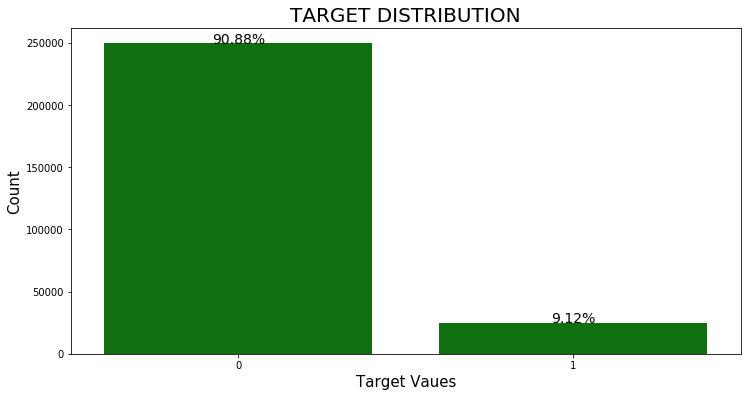

In [29]:
plt.figure(figsize=(12,6))


g = sns.countplot(x='Target', data=fire_df_visuals, color='green')
g.set_title("TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Vaues", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)


for p in g.patches:
    g.text( p.get_x()+p.get_width()/2,     p.get_height()+3,    '{:1.2f}%'.format(p.get_height()/len(fire_df)*100), ha="center", fontsize=14) 

plt.show()

**THE TARGET DISTRIBUTION IS HIGHLY IMBALANCED. WE WILL EMPLOY OVERSAMPLING TO BALANCE THE CLASS. FOR NOW, LETS EXPLORE THE ACTUAL FEATURES.** 

In [30]:
print ("*"*115)

*******************************************************************************************************************


### 3B. FEATURE DISTRIBUTIONS

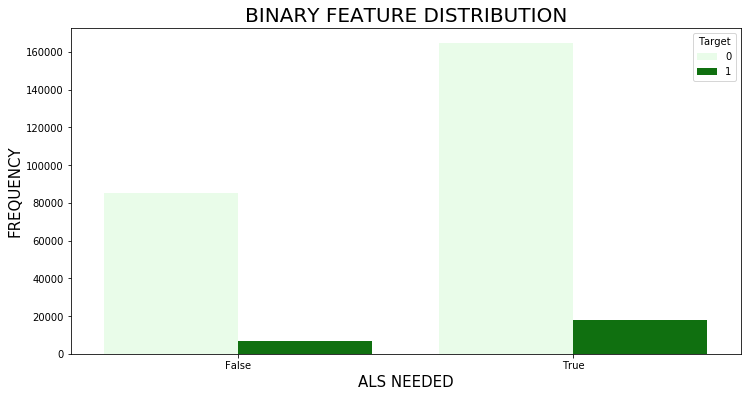

In [31]:
plt.figure(figsize=(12,6))


ax=sns.countplot(x='ALS Unit', data=fire_df_visuals, color='green',hue="Target")

ax.set_title("BINARY FEATURE DISTRIBUTION", fontsize = 20)
ax.set_xlabel("ALS NEEDED", fontsize = 15)
ax.set_ylabel("FREQUENCY", fontsize = 15)


plt.show()

In [32]:
def crosstab_percentages(target,categorical_column):
    Target_Distribution=pd.crosstab(fire_df_visuals["Target"],fire_df_visuals[categorical_column])
    Target_Distribution_Percentage=Target_Distribution/Target_Distribution.sum()
    stat, p, dof, expected = sc.chi2_contingency(Target_Distribution)
    print ("Chi_Squared_value = " +"{0:.7f}".format(p))
    return (Target_Distribution_Percentage.round(decimals=2)*100).astype(int).astype(str)+"%"

# Binary_Target_Distribution=pd.crosstab(fire_df_visuals["Target"],fire_df_visuals["ALS Unit"])
# Binary_Target_Distribution_Percentage=Binary_Target_Distribution/Binary_Target_Distribution.sum()

# (Binary_Target_Distribution_Percentage.round(decimals=2)*100).astype(int).astype(str)+"%"

crosstab_percentages(fire_df_visuals["Target"],"ALS Unit")

Chi_Squared_value = 0.0000000


ALS Unit,False,True
Target,,
0,92%,90%
1,8%,10%


**This feature does not seem to be a good indicator of the target.**

In [33]:
print ("*"*115)

*******************************************************************************************************************


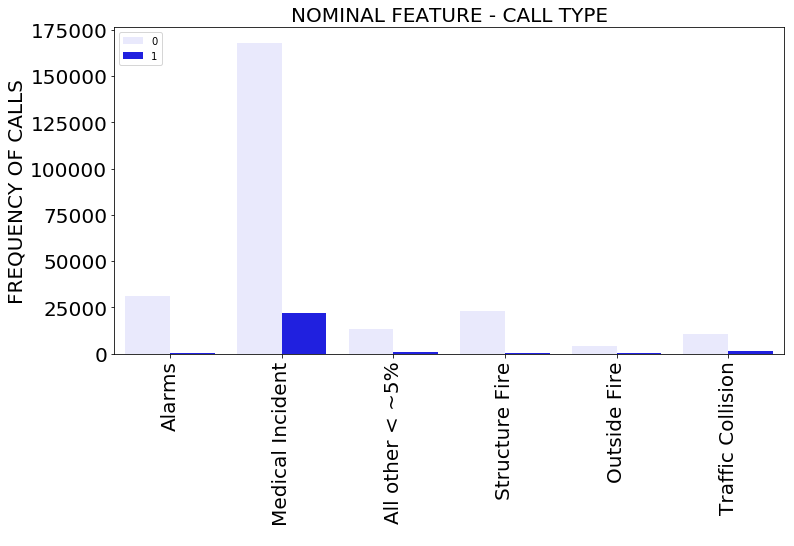

In [34]:
plt.figure(figsize=(12,6))

sns.countplot(x="Call Type",data=fire_df_visuals,color='blue', hue="Target").tick_params(labelsize=20)
plt.xticks(rotation='vertical')
plt.xlabel(" ")
plt.ylabel("FREQUENCY OF CALLS",fontsize=20)
plt.title("NOMINAL FEATURE - CALL TYPE",fontsize=20)
plt.legend(loc=2)
plt.show()

In [35]:
crosstab_percentages(fire_df_visuals["Target"],"Call Type")

Chi_Squared_value = 0.0000000


Call Type,Alarms,All other < ~5%,Medical Incident,Outside Fire,Structure Fire,Traffic Collision
Target,,,,,,
0,99%,94%,89%,94%,98%,87%
1,1%,6%,11%,6%,2%,13%


**This feature does not seem to be a good indicator of the target.**

In [36]:
print ("*"*115)

*******************************************************************************************************************


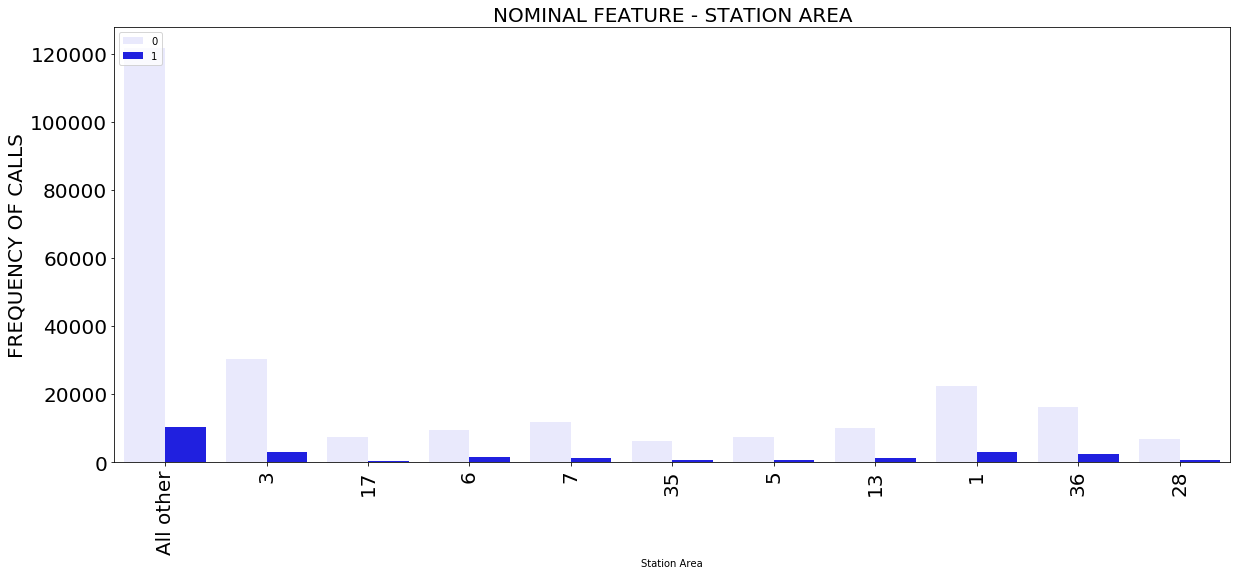

In [37]:
plt.figure(figsize=(20,8))
sns.countplot(x="Station Area",data=fire_df_visuals,color='blue', hue="Target").tick_params(labelsize=20)
plt.xticks(rotation='vertical')
#plt.xlabel("STATION AREA",fontsize=20)
plt.ylabel("FREQUENCY OF CALLS",fontsize=20)
plt.title("NOMINAL FEATURE - STATION AREA",fontsize=20)
plt.legend(loc=2)
plt.show()

In [38]:
crosstab_percentages(fire_df_visuals["Target"],"Station Area")

Chi_Squared_value = 0.0000000


Station Area,1,13,17,28,3,35,36,5,6,7,All other
Target,,,,,,,,,,,
0,89%,89%,94%,91%,91%,91%,87%,93%,87%,90%,92%
1,11%,11%,6%,9%,9%,9%,13%,7%,13%,10%,8%


**This feature does not seem to be a good indicator of the target.**

In [39]:
print ("*"*115)

*******************************************************************************************************************


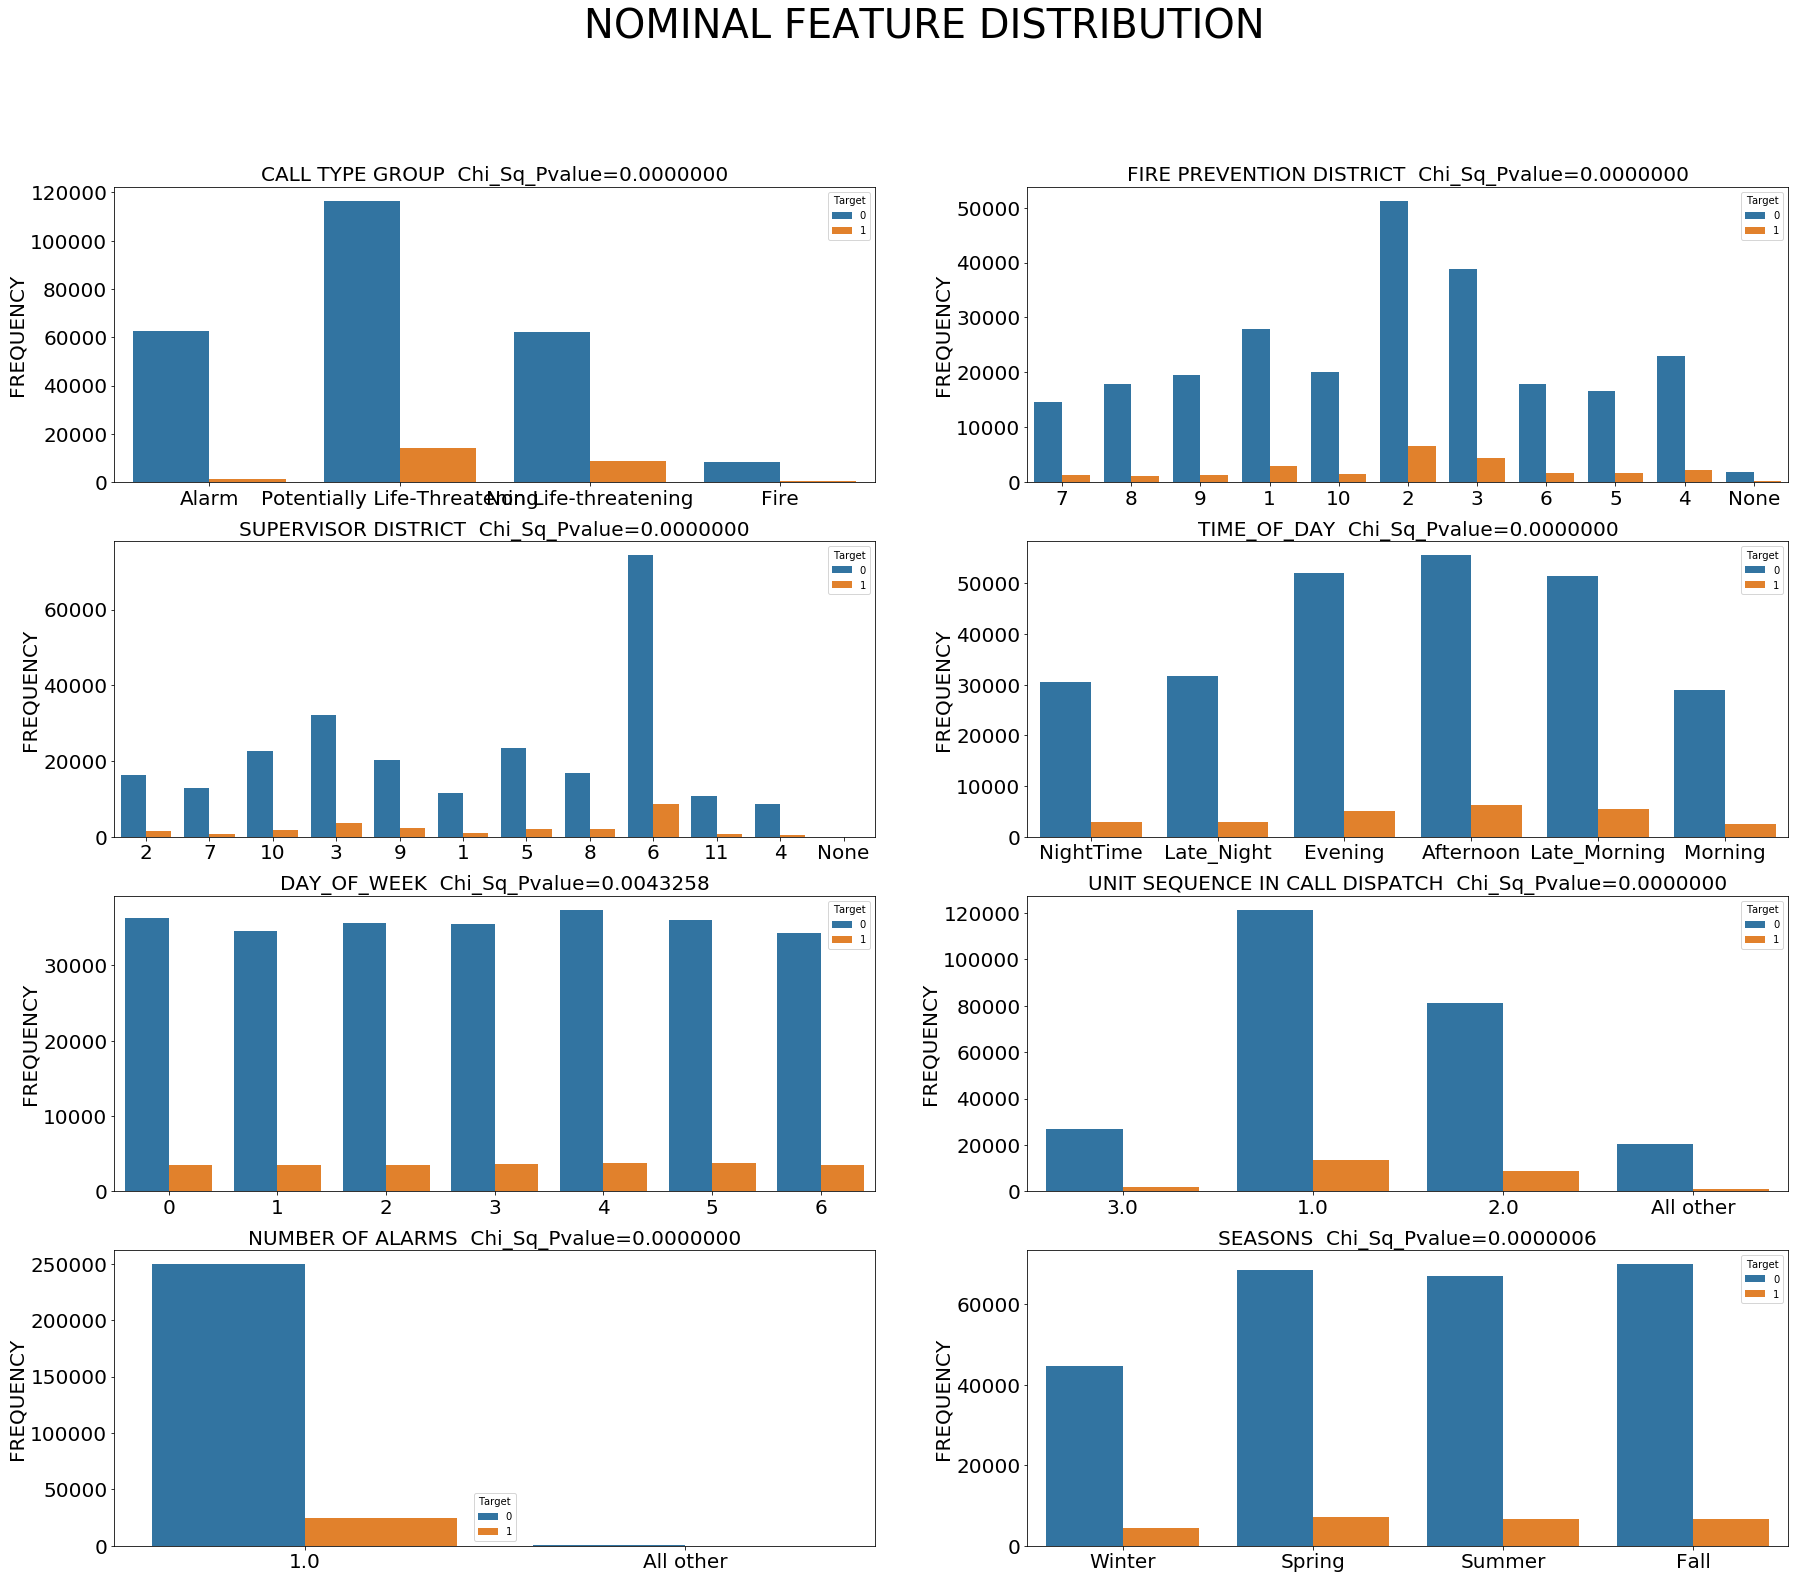

In [40]:
Nominal_Features=['Call Type Group', 'Fire Prevention District', 'Supervisor District', 'Time_of_Day','Day_of_Week',"Unit sequence in call dispatch",'Number of Alarms','Seasons']

fig, ax = plt.subplots(4,2, figsize=(30, 25))

for i in range(len(Nominal_Features)):
    sns.countplot(x=fire_df_visuals[Nominal_Features[i]],data=fire_df_visuals,ax=ax[i//2][i%2], hue="Target").tick_params(labelsize=20)
    Nominal_Target_Distribution=pd.crosstab(fire_df_visuals["Target"],fire_df_visuals[Nominal_Features[i]])
    stat, p, dof, expected = sc.chi2_contingency(Nominal_Target_Distribution)
    ax[i//2][i%2].set_title(Nominal_Features[i].upper() +"  "+"Chi_Sq_Pvalue=" +"{0:.7f}".format(p),fontsize=20)
    ax[i//2][i%2].set_ylabel("FREQUENCY",fontsize=20)
    ax[i//2][i%2].set_xlabel("  ")
    
    
    
    

fig.suptitle("NOMINAL FEATURE DISTRIBUTION", fontsize=40)
plt.show()

In [41]:
crosstab_percentages(fire_df_visuals["Target"],"Call Type Group")

Chi_Squared_value = 0.0000000


Call Type Group,Alarm,Fire,Non Life-threatening,Potentially Life-Threatening
Target,,,,
0,98%,95%,87%,89%
1,2%,5%,13%,11%


**This feature does not seem to be a good indicator of the target.**

In [42]:
crosstab_percentages(fire_df_visuals["Target"],"Fire Prevention District")

Chi_Squared_value = 0.0000000


Fire Prevention District,1,10,2,3,4,5,6,7,8,9,None
Target,,,,,,,,,,,
0,91%,93%,89%,90%,91%,91%,91%,92%,94%,94%,91%
1,9%,7%,11%,10%,9%,9%,9%,8%,6%,6%,9%


**This feature does not seem to be a good indicator of the target.**

In [43]:
crosstab_percentages(fire_df_visuals["Target"],"Supervisor District")

Chi_Squared_value = 0.0000000


Supervisor District,1,10,11,2,3,4,5,6,7,8,9,None
Target,,,,,,,,,,,,
0,92%,93%,94%,91%,90%,94%,92%,89%,94%,89%,90%,73%
1,8%,7%,6%,9%,10%,6%,8%,11%,6%,11%,10%,27%


**This feature does not seem to be a good indicator of the target.**

In [44]:
crosstab_percentages(fire_df_visuals["Target"],"Time_of_Day")

Chi_Squared_value = 0.0000000


Time_of_Day,Afternoon,Evening,Late_Morning,Late_Night,Morning,NightTime
Target,,,,,,
0,90%,91%,91%,92%,92%,91%
1,10%,9%,9%,8%,8%,9%


**This feature does not seem to be a good indicator of the target.**

In [45]:
crosstab_percentages(fire_df_visuals["Target"],"Day_of_Week")

Chi_Squared_value = 0.0043258


Day_of_Week,0,1,2,3,4,5,6
Target,,,,,,,
0,91%,91%,91%,91%,91%,90%,91%
1,9%,9%,9%,9%,9%,10%,9%


**This feature does not seem to be a good indicator of the target.**

In [46]:
crosstab_percentages(fire_df_visuals["Target"],"Unit sequence in call dispatch")

Chi_Squared_value = 0.0000000


Unit sequence in call dispatch,1.0,2.0,3.0,All other
Target,,,,
0,90%,90%,94%,95%
1,10%,10%,6%,5%


**This feature does not seem to be a good indicator of the target.**

In [47]:
crosstab_percentages(fire_df_visuals["Target"],"Number of Alarms")

Chi_Squared_value = 0.0000000


Number of Alarms,1.0,All other
Target,,
0,91%,100%
1,9%,0%


**This feature does not seem to be a good indicator of the target.**

In [48]:
crosstab_percentages(fire_df_visuals["Target"],"Seasons")

Chi_Squared_value = 0.0000006


Seasons,Fall,Spring,Summer,Winter
Target,,,,
0,91%,90%,91%,91%
1,9%,10%,9%,9%


**This feature does not seem to be a good indicator of the target.**

In [49]:
print ("*"*115)

*******************************************************************************************************************


### Numerical Values

In [50]:
print("Variance of continous features")
print(fire_df_visuals[["Longitude","Latitude","Target"]].var())  
print("*"*115)
print("Even though variance of these continous features is extremely low (therefore making them a candidate for feature extraction), the nature of the feature (being coordinates) is such that we will not extract these features. We will take correlation of these features to assess for any multicollinearity")
print("*"*115)
fire_df_visuals[["Longitude","Latitude","Target"]].corr()

Variance of continous features
Longitude    0.000586
Latitude     0.000727
Target       0.082886
dtype: float64
*******************************************************************************************************************
Even though variance of these continous features is extremely low (therefore making them a candidate for feature extraction), the nature of the feature (being coordinates) is such that we will not extract these features. We will take correlation of these features to assess for any multicollinearity
*******************************************************************************************************************


,Longitude,Latitude,Target
Longitude,1.000000,0.228215,0.038841
Latitude,0.228215,1.000000,0.030335
Target,0.038841,0.030335,1.000000


<Figure size 1440x576 with 0 Axes>

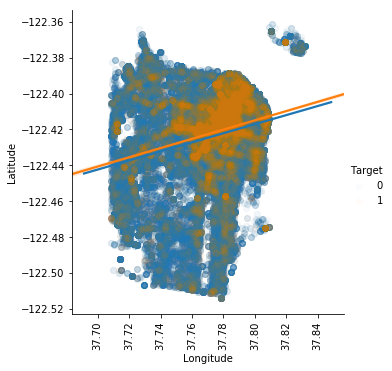

From the scatterplot, we can conclude that a high concentration of false 911 calls were made from the same geographical area


In [51]:
plt.figure(figsize=(20,8))
sns.lmplot(x="Longitude",y="Latitude",data=fire_df_visuals,hue="Target",scatter_kws={'alpha':.02})
plt.xticks(rotation='vertical')
plt.show()

print("From the scatterplot, we can conclude that a high concentration of false 911 calls were made from the same geographical area")

In [52]:
fire_df_visuals[["Longitude","Latitude","Target"]].describe()  

#Getting basic info about longitude/latitude (min,max)

,Longitude,Latitude,Target
count,274866.000000,274866.000000,274866.000000
mean,37.769633,-122.424553,0.091204
std,0.024211,0.026965,0.287900
min,37.708256,-122.513648,0.000000
25%,37.756494,-122.435001,0.000000
50%,37.777799,-122.417261,0.000000
75%,37.785466,-122.408013,0.000000
max,37.831666,-122.361475,1.000000


In [53]:
print("*"*115)
print("From the stats above, we note that the median value is greater than the mean - indicating the distribution is going to be skewed to the left. Lets see if this is true by drawing histograms.")

*******************************************************************************************************************
From the stats above, we note that the median value is greater than the mean - indicating the distribution is going to be skewed to the left. Lets see if this is true by drawing histograms.


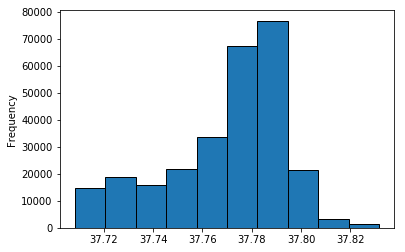

In [54]:
fire_df_visuals["Longitude"].plot.hist(edgecolor="black")
plt.show()

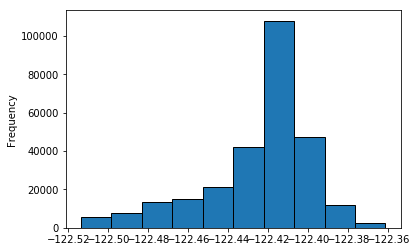

In [55]:
fire_df_visuals["Latitude"].plot.hist(edgecolor="black")
plt.show()

### Conclusion from Data Exploration: there does not seem to be any linear relationship between any of the features and the target. As such, during our modeling phase, we can expect Logistic Regression to not have high accuracy metrics.

### 3C. OVER SAMPLING TO COUNTER TARGET IMBALANCE ###

Because of the target class imbalance (90/10), we are synthetically adding the minority class for better prediction purposes.

In [56]:
fire_df_target_positive=fire_df[fire_df["Target"]==1] 

fire_df=fire_df.append(fire_df_target_positive)
fire_df=fire_df.append(fire_df_target_positive)
fire_df=fire_df.append(fire_df_target_positive)
fire_df=fire_df.append(fire_df_target_positive)
fire_df=fire_df.append(fire_df_target_positive)
fire_df=fire_df.append(fire_df_target_positive)
fire_df=fire_df.append(fire_df_target_positive)

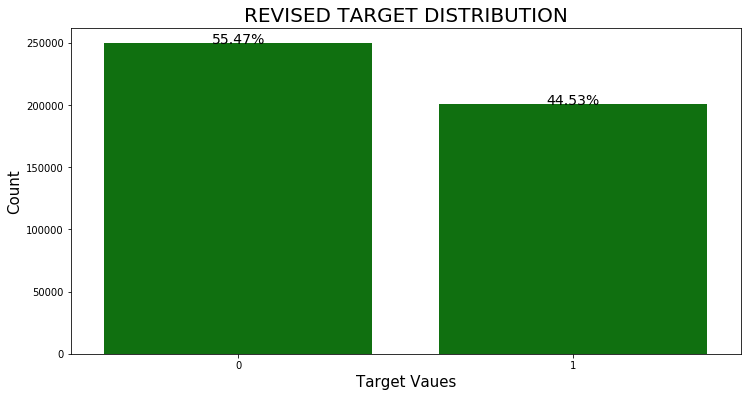

In [57]:
plt.figure(figsize=(12,6))


g = sns.countplot(x='Target', data=fire_df, color='green')
g.set_title("REVISED TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Vaues", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)


for p in g.patches:
    g.text( p.get_x()+p.get_width()/2,     p.get_height()+3,    '{:1.2f}%'.format(p.get_height()/len(fire_df)*100), ha="center", fontsize=14) 

plt.show()

In [58]:
fire_df.shape

(450349, 65)

## 4. MODELING ##

In [59]:
y=fire_df["Target"]
X=fire_df.drop("Target",axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=2)

### **4A. BASELINE**  ###

In [61]:
lrc=LogisticRegression(random_state=1)  # default C=1, penalty =l2 (Ridge)
lrc.fit(X_train,y_train)
y_pred=lrc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Accuracy is:'+str(round(accuracy_score(y_test, y_pred),2)))
print('Precision is:'+str(round(precision_score(y_test, y_pred),2)))
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

LogReg=round(recall_score(y_test, y_pred, average='binary'),2)

cross_val_score(lrc, X, y, cv=5, scoring='recall')

col_0       0      1
Target              
0       48505  26199
1       25082  35319
**************************************************
Accuracy is:0.62
Precision is:0.57
Recall is:0.58
F1 score is:0.58
**************************************************


array([0.51721473, 0.41253023, 0.62488158, 0.50244328, 0.54632261])

**Comments**: As expected, metrics from the Confusion matrix are relatively low. Because we really want to minimize Type 2 error, we will look for another algorithm with less False negatives and a better recall score.

In [62]:
print("*"*115)

*******************************************************************************************************************


### **4B. BAGGING ALGORITHM (Parallel Learners - Random Forest)**  ###

In [63]:
rfc=RandomForestClassifier(random_state=1)  #n_estimators = 10, max_depth=none   max_features = sqrt(# of features),  min_leaf =1,  min_split =2
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Accuracy is:'+str(round(accuracy_score(y_test, y_pred),2)))
print('Precision is:'+str(round(precision_score(y_test, y_pred),2)))
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

Random_Forest=round(recall_score(y_test, y_pred, average='binary'),2)

cross_val_score(rfc, X, y, cv=5, scoring='recall')

col_0       0      1
Target              
0       72111   2593
1          40  60361
**************************************************
Accuracy is:0.98
Precision is:0.96
Recall is:1.0
F1 score is:0.98
**************************************************


array([0.99995014, 1.        , 1.        , 1.        , 1.        ])

**Comments**:: At first glance, there seems to be something wrong with out model. It is giving a perfect recall score. It could be overfitting but the score is on the ... test dataset? 


One possible reason for such scores could be that the test portion is rather small. However, we increased our testing size from the original 25% to 30% but did not see any changes in scoring metrics.

Another possible reason for such scores could be that the test dataset is very similar to the training dataset. In such cases, our model would work if new data is indeed very similar to trained data. One way to test that would be to feed a similar dataset from a different city to assess the quality of the model.

Lastly, we scrutinized the default parameters and noticed that the depth of the tree is not indicated, the min_samples_split is 2 and the min_samples_leaf is 1! In short, it is a very long tree. Because our dataset is relatively small, it is not computation-expensive to have such a long tree with a leaf of 1. However if our dataset was much larger, it would be very memory-intensive to generate such a tree on a scale indicated by the number of trees parameter. 

To anticipate larger datasets, we will now employ the same model but we will tune in the hyperparameters resulting in a bit more variance and lower scoring metrics.

**Random Forest - tuning parameters**

In [64]:
rfc=RandomForestClassifier(n_estimators=100, min_samples_split=40, min_samples_leaf=20,max_depth=10,random_state=1)  #n_estimators = 10, max_depth=none   max_features = sqrt(# of features),  min_leaf =1,  min_split =2
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Accuracy is:'+str(round(accuracy_score(y_test, y_pred),2)))
print('Precision is:'+str(round(precision_score(y_test, y_pred),2)))
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

Random_Forest_tuned=round(recall_score(y_test, y_pred, average='binary'),2)

cross_val_score(rfc, X, y, cv=5, scoring='recall')

col_0       0      1
Target              
0       51696  23008
1       22233  38168
**************************************************
Accuracy is:0.67
Precision is:0.62
Recall is:0.63
F1 score is:0.63
**************************************************


array([0.58976341, 0.51576874, 0.66706557, 0.58925455, 0.64303166])

**Comments**: Based on rule-of-thumb parameters tuning, best recall score we can get is 63%. Let's try boosting algorithms to see if we can get a better score.

### **4C. BOOSTING ALGORITHM (Sequential Learners)**  ###

**GradientBoosting Classifer**

In [65]:
gbc = GradientBoostingClassifier(n_estimators=100, min_samples_split=40, min_samples_leaf=20,max_depth=10,random_state=1)
gbc.fit(X_train,y_train)
y_pred=gbc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Accuracy is:'+str(round(accuracy_score(y_test, y_pred),2)))
print('Precision is:'+str(round(precision_score(y_test, y_pred),2)))
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

Grad_Boost_I=round(recall_score(y_test, y_pred, average='binary'),2)

col_0       0      1
Target              
0       59476  15228
1       11801  48600
**************************************************
Accuracy is:0.8
Precision is:0.76
Recall is:0.8
F1 score is:0.78
**************************************************


**Comments**: Through GBC, we were able to improve our recall score using identical parameters as random forest to 80%. This does make sense since each classifier is built sequentially learning from the previous classifer. Even though we were able to get a score of 80%, lets try another boosting algorithm, Adaboost, to see if we can get even a better score. 

**AdaBoost**

In [66]:
abc = AdaBoostClassifier(n_estimators=100, learning_rate=1,random_state=1)
abc.fit(X_train,y_train)
y_pred=abc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Accuracy is:'+str(round(accuracy_score(y_test, y_pred),2)))
print('Precision is:'+str(round(precision_score(y_test, y_pred),2)))
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

AdaBoost=round(recall_score(y_test, y_pred, average='binary'),2)

col_0       0      1
Target              
0       49242  25462
1       25679  34722
**************************************************
Accuracy is:0.62
Precision is:0.58
Recall is:0.57
F1 score is:0.58
**************************************************


**Comments**: Our recall score went down in this algorithm. So far, our highest score is 80%. Lets try to perform a bit of additional feature engineering by narrowing down important features from Gradient Boosting Classifer.

### **4D. FEATURE IMPORTANCE**  ###

Text(0.5, 1.0, 'Feature Importance (GBC)')

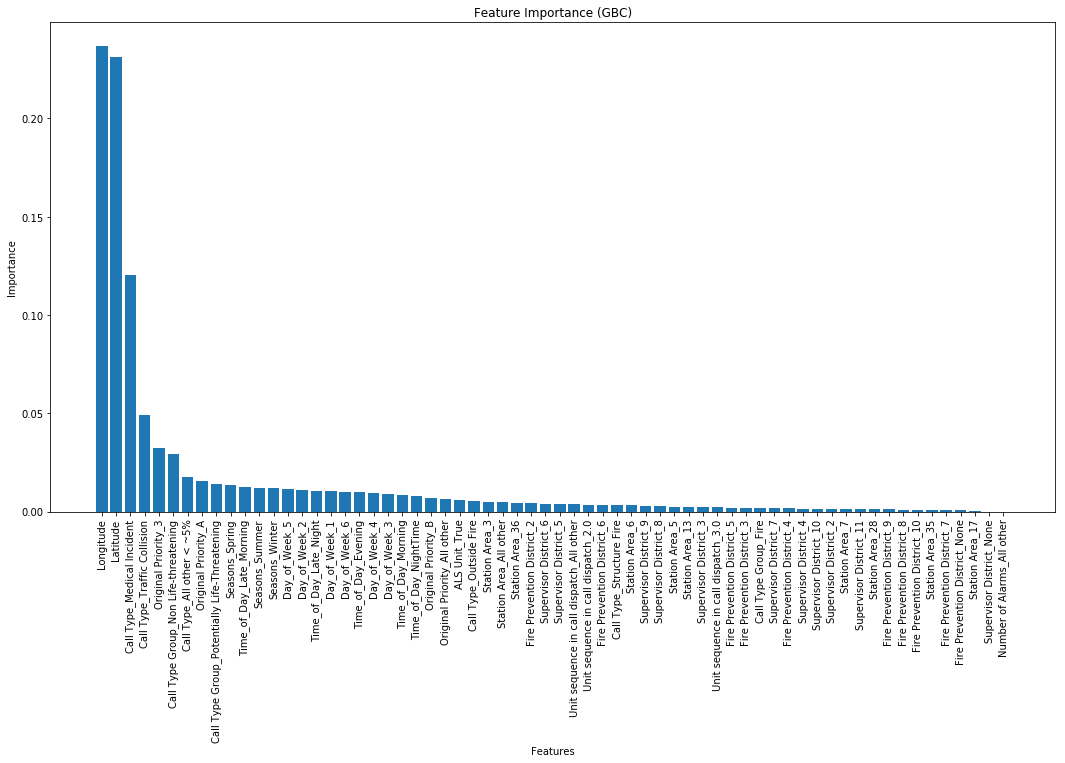

In [67]:
Importance=gbc.feature_importances_
Columns=X_train.columns

Importance,Columns=zip(*sorted(zip(Importance, Columns),reverse=True))


plt.figure(figsize=(18,9))
plt.xticks(rotation="vertical")
plt.bar(x=Columns,height=Importance)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.title ("Feature Importance (GBC)")

In [68]:
Importance=np.array(Importance)
np.where(Importance.cumsum()>.90)  #retrieving the number of features that make up 90% of the value

(array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63], dtype=int64),)

### **4E. GRADIENT BOOST - AFTER FEATURE EXTRACTION**  ###

In [69]:
#Setting up new dataframe with features that make up 90% of the value

X_revised=X[list(Columns[:24])]  
y=fire_df["Target"]

In [70]:
X_train_rev, X_test_rev, y_train, y_test = train_test_split(X_revised, y, test_size=0.30,random_state=2)

In [71]:
gbc_rev = GradientBoostingClassifier(n_estimators=100, min_samples_split=40, min_samples_leaf=20,max_depth=10,random_state=1)
gbc_rev.fit(X_train_rev,y_train)
y_pred=gbc_rev.predict(X_test_rev)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Accuracy is:'+str(round(accuracy_score(y_test, y_pred),2)))
print('Precision is:'+str(round(precision_score(y_test, y_pred),2)))
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

Grad_Boost_II=round(recall_score(y_test, y_pred, average='binary'),2)

col_0       0      1
Target              
0       59889  14815
1       11310  49091
**************************************************
Accuracy is:0.81
Precision is:0.77
Recall is:0.81
F1 score is:0.79
**************************************************


**Comments**: GradientBoosting after feature extraction seems to have the highest score.

## **5. CONCLUSION**  ##

In [72]:
Classifers=['Log_Reg', 'Random_Forest(no tuning)', 'Random_Forest(tuned)', "Grad_Boost(tuned)", "AdaBoost", "Grad_Boost( * FI)" ]

Scores=[LogReg, Random_Forest, Random_Forest_tuned, Grad_Boost_I, AdaBoost, Grad_Boost_II ]

Scores_df=pd.DataFrame(list(zip(Classifers,Scores)),columns=["Classifiers","Scores"])

Scores_df.sort_values("Scores")

,Classifiers,Scores
4,AdaBoost,0.57
0,Log_Reg,0.58
2,Random_Forest(tuned),0.63
3,Grad_Boost(tuned),0.80
5,Grad_Boost( * FI),0.81
1,Random_Forest(no tuning),1.00


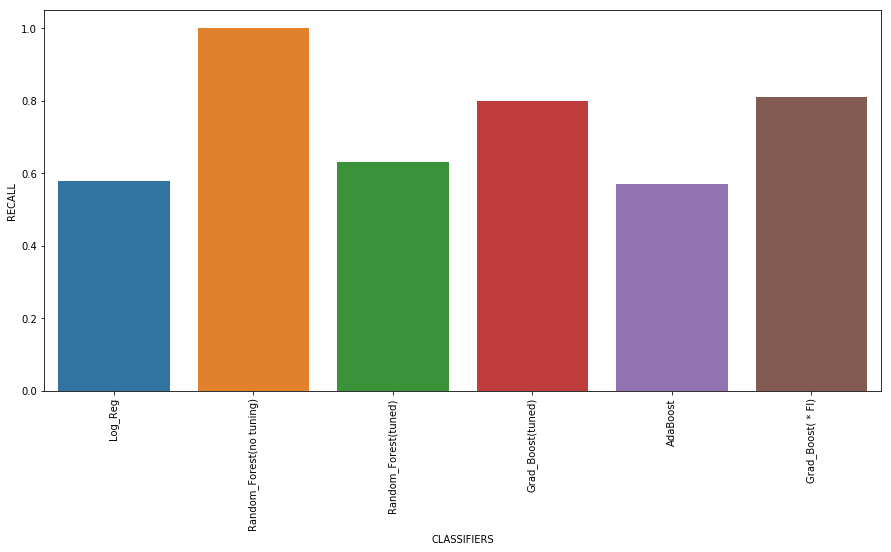

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(15,7)
sns.barplot(x="Classifiers", y="Scores", data=Scores_df, ax=ax)
plt.ylabel('RECALL')
plt.xlabel('CLASSIFIERS')
plt.xticks(rotation='vertical')
plt.show()



### 5A. WINNER ###

**Winner : Gradient Boosting(*after Feature Importance)**. Even though Random Forest (with no tuning) scores the highest recall score (virtually 100%), it may be susceptible to overfitting on larger datasets. As such, we would go with the second highest score - which is Gradient Boosting (after Feature extraction). Its recall score of 81% is marginally higher than the original Gradient Boosting score of 80% and the model is flexible enough to handle larger different datasets. 